# Robotic Systems I (ECE-DK808)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 3

### Car-like Mobile Robot

We have the following car-like mobile robot:

<img src="car.png" width="300px"/>

The robot is moving on the 2D plane and has the following state: $\boldsymbol{x} = [\theta, x, y]^T$.

We can control the car by steering the wheel $\delta$ and generating driving velocity $v$ (e.g. via the pedal). It holds that $-\frac{\pi}{3}\leq\delta\leq\frac{\pi}{3}$, and $\boldsymbol{u} = \begin{bmatrix}v\\\delta\end{bmatrix}$. The car has length $L$.

The kinematic equations are given by:

$\dot{\boldsymbol{x}} = \begin{bmatrix}\frac{v}{L}\tan\delta\\v\cos\theta\\v\sin\theta\end{bmatrix}$

The task of this lab is to perform motion planning for this vehicle with RRT.

In [12]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
from matplotlib.patches import Rectangle, Circle # for visualizing the robot and the obstacles
import copy

In [13]:
# First let's define the kinematics
L = 0.25

def car(x, u):
    # $\dot{x} = f(x,u)$
    return np.array([[u[0, 0] / L * np.tan(u[1, 0]), u[0, 0] * np.cos(x[0, 0]), u[0, 0] * np.sin(x[0, 0])]]).T

In [14]:
# Let's create a `simulate_car` function that perform a few steps of simulation using rk4
def rk4(f, x, u, dt):
    f1 = f(x, u)
    f2 = f(x + 0.5*dt*f1, u)
    f3 = f(x + 0.5*dt*f2, u)
    f4 = f(x + dt*f3, u)
    return x + dt/6.*(f1 + 2.*f2 + 2.*f3 + f4)

def simulate_car(x0, u_list, dt):
    # The function performs a simulation of K steps using the controls in u_list
    # x0 - initial state
    # u_list - list of control inputs, len(u_list) defines the number of steps, K
    # dt - discretization
    K = len(u_list)
    x = np.copy(x0)
    states = [x]
    for k in range(K):
        x = rk4(car, x, u_list[k], dt)
        states.append(x)
    return states

In [15]:
# A helper function to visualize trajectories
def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
def draw_rectangle(ax, p, angle, alpha = 1.):
    # p is the center of the rectangle
    Al = np.array([[L/2., L/4.]]).T
    Bl = np.array([[L/2., -L/4.]]).T
    Cl = np.array([[-L/2., -L/4.]]).T
    Dl = np.array([[-L/2., L/4.]]).T
    El = np.array([[L/2. + L/4., 0.]]).T

    A = rot(angle) @ Al + p
    B = rot(angle) @ Bl + p
    C = rot(angle) @ Cl + p
    D = rot(angle) @ Dl + p
    E = rot(angle) @ El + p

    # points = [A, B, C, D]
    # for p in points:
    #     ax.plot(p[0, 0], p[1, 0], '.', color='black', zorder=2, alpha = alpha)
    pair_points = [(B, C), (C, D), (D, A), (A, E), (E, B)]
    for (p1, p2) in pair_points:
        ax.plot([p1[0, 0], p2[0, 0]], [p1[1, 0], p2[1, 0]], '-', color='black', zorder=2, alpha = alpha)

def visualize_trajectory(states, start_alpha = 0.1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    final_alpha = 1.
    prev_p = None
    for k in range(len(states)):
        # alpha = start_alpha + k / float(len(states)) * (final_alpha - start_alpha)
        alpha = start_alpha * np.power(final_alpha / start_alpha, float(k)  / float(len(states)))
        p = states[k]
        # compute positions
        bpb = np.array([[0., 0.]]).T
        bpw = rot(p[0, 0]) @ bpb + p[1:, :]

        draw_rectangle(ax, p[1:,:], p[0, 0], alpha)

        if prev_p is not None:
            ax.plot([prev_p[0, 0], bpw[0, 0]], [prev_p[1, 0], bpw[1, 0]], '-', alpha = alpha)
        prev_p = np.copy(bpw)
        ax.plot(bpw[0, 0], bpw[1, 0], 'o', markersize=5, alpha = alpha)
    
    # Set the limits for the environment
    plt.xlim(-1, 1);
    plt.ylim(-1, 1);

Let's try out our functions to see how they work.

[[0.75543951 0.76064018]]


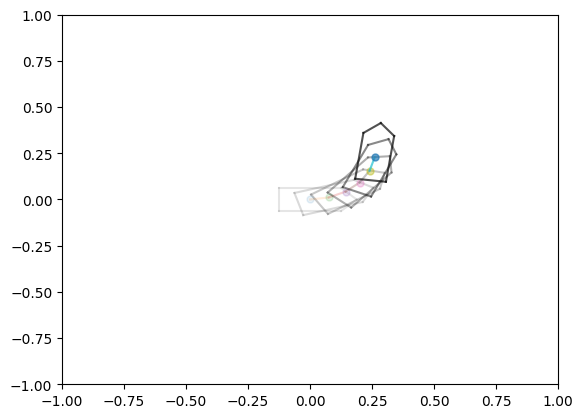

In [16]:
# We want K steps
K = 5
# We set the dt
dt = 0.1


# Helper function to create random control input (with some limits)
def random_ctrl():
    u = np.random.rand(2, 1)
    u[0, 0] = u[0, 0] * 2. - 1.
    u[1, 0] = u[1, 0] * 2. * np.pi / 3. - np.pi / 3.
    return u

# Let's first create a list of random control inputs
u_rand = random_ctrl()
print(u_rand.T)
u_list = [u_rand for k in range(K)] # we use the same control for all K steps (not necessary)

# Let's do the simulation
x0 = np.array([[0., 0., 0.]]).T

states = simulate_car(x0, u_list, dt)

visualize_trajectory(states)

### Randomly exploring Rapid Trees (RRT)

RRT is a simple but effective algorithm for planning. It is a sampling based planning algorithm. A high level pseudocode is given below:

1. Initialize search tree with $\boldsymbol{x}_{\text{start}}$
2. $\textbf{while}$ *some stopping criteria are not met*
3. &nbsp;&nbsp;&nbsp;&nbsp;sample $\boldsymbol{x}_{\text{sample}}\sim\mathcal{X}$
4. &nbsp;&nbsp;&nbsp;&nbsp;find $\boldsymbol{x}_{\text{nearest}}\text{ nearest node of } \boldsymbol{x}_{\text{sample}} \text{ in tree}$
5. &nbsp;&nbsp;&nbsp;&nbsp;connect $\boldsymbol{x}_{\text{nearest}} \text{ to } \boldsymbol{x}_{\text{new}} \text{ in direction of } \boldsymbol{x}_{\text{sample}}$
6. &nbsp;&nbsp;&nbsp;&nbsp;$\textbf{if}\text{ success}$
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;add $\boldsymbol{x}_{\text{new}} \text{ to the tree with an edge from }\boldsymbol{x}_{\text{nearest}}$
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\textbf{if }\boldsymbol{x}_{\text{new}}\in\mathcal{X}_{\text{goal}}\text{ return SUCCESS}$
9. $\text{~return FAILURE}$

We will now implement RRT for our car-like robot.

The key difference between RRT in simple (or holonomic) systems and RRT in more complex systems is in the connect function. In complex systems, we have no analytic way to "connect" $\boldsymbol{x}_{\text{nearest}} \text{ to } \boldsymbol{x}_{\text{new}} \text{ in the direction of } \boldsymbol{x}_{\text{sample}}$. We will implement the following procedure for the connect function.

**connect**($\boldsymbol{x}_{\text{nearest}}$, $\boldsymbol{x}_{\text{sample}}$):
1. We create a distance function that defines how distinct two states $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$ are.
   - In particular, we will use the following $d(\boldsymbol{x}_i, \boldsymbol{x}_j) = 0.1\delta\theta^2 + \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$, where $\delta\theta$ is the smallest angle difference between $\theta_j$ and $\theta_i$.
2. We generate $N$ trajectories of maximum $K$ steps with random control inputs: $\boldsymbol{x}_i^k$ denotes the $k$-step of the $i$-th trajectory.
3. For each trajectory $i$, we compute the distance between all steps and $\boldsymbol{x}_{\text{sample}}$: $J_i = \sum_kd(\boldsymbol{x}_i^k, \boldsymbol{x}_{\text{sample}})$.
4. We keep the trajectory with the minimum distance, $i_{min}$
5. We return the final state of the trajectory, $\boldsymbol{x}_{i_{min}}^K$


Let's implement the RRT for this car.

In [17]:
# First, some helpers
def numpy_to_tuple(xx):
    x = xx.reshape((-1, 1))
    return (x[0, 0], x[1, 0], x[2, 0])

# And for the inverse
def tuple_to_numpy(t):
    return np.array([[t[0], t[1], t[2]]]).T

In [18]:
# Now we need to create a sampler!
def sample_state():
    ### TO-DO: Sample a state in [(-π, -1, -1), (π, 1, 1)] and return it. You should use `np.random.rand()` only once!
    ### ANSWER: Insert code here
    l = np.array([-np.pi, -1., -1.]).reshape(3,1)
    u = np.array([np.pi, 1., 1.]).reshape(3,1)
    
    s = l + (u - l) * np.random.rand(3, 1)
    
    return s
    ### END of ANSWER

# Let's define our distance function
def dist(x, y):
    ### TO-DO: Write down the distance function that we defined above: $d(\boldsymbol{x}_i, \boldsymbol{x}_j) = 0.1\delta\theta^2 + \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$
    ### store the result in a variable named 'd'
    ### ANSWER: Insert code here
    delta_theta = np.arctan2(np.sin(y[0] - x[0]), np.cos(y[0] - x[0]))
    
    xi = x[1]
    xj = y[1]
    yi = x[2]
    yj = y[2]
    
    d = 0.1 * delta_theta**2 + np.sqrt((xj - xi)**2 + (yj - yi)**2)
    ### END of ANSWER
    return d

# Now we need to find the nearest node of x in tree
def nearest(x, tree):
    ### TO-DO: Find the nearest node using the above defined distance. Store it in a variable named 'near' (a numpy array). 'x' is a numpy array.
    ### Hint: `tree` is of the following form: tree = { (x_i, y_i) : [(x_ik, y_ik)] }
    ### ANSWER: Insert code here 
    tree = sorted(tree) # initial tree is a 'set'
    near = np.array([[tree[0][0]], [tree[0][1]], [tree[0][2]]])
    min_dist = dist(near, x)
    
    for t in tree:
        current_node = np.array([t]).T 
        if(dist(current_node, x) < min_dist):
            min_dist = dist(current_node, x)
            near = current_node
    ### END of ANSWER
    return near
    
# Finally we need to connect two states
def connect(x_start, x_target, eps_goal = 0.1):
    ### TO-DO: Connect the two states via the procedure as defined above (x_start is a numpy array). Save the result in a variable named 'x_final' (numpy array).
    ### Hint: Use the `simulate_car` function, and assume that for each trajectory we apply one random action for all K steps.
    ### Hint: We stop early if we reach the target (dist < eps_goal).
    ### Use `random_ctrl()` function to generate the random action(s).
    ### Use N = 100, K = 2, dt = 0.1
    ### ANSWER: Insert code here
    N = 100
    K = 2
    dt = 0.1

    min_dist = 5.
    
    for i in range(N):
        distance = 0.
        u_rand = random_ctrl()
        u_list = [u_rand for k in range(K)]

        states = simulate_car(x_start, u_list, dt)
        for s in states:
            distance += dist(s, x_target)
                    
        if(distance < min_dist):
            min_dist = distance
            x_final = states[2]
            if (distance < eps_goal): break
    ### END of ANSWER
    return x_final

def valid_state(x):
    # We do not allow states outside [-1., 1.], angles can be of any value (they "wrap" around)
    if (np.abs(x[1:]) > 1.).any():
        return False
    return True

In [19]:
for _ in range(50):
    x_rand = sample_state()
    assert((np.abs(x_rand[1:,:]) <= 1.).all())
    assert((np.abs(x_rand[0:1,:]) <= np.pi).all())

In [20]:
mytree = {(0., 0., 0.) : [], (0., 1., 1.) : [], (3., 0., 0.) : [], (0., 0.5, 0.5) : []}

x1 = np.array([[0.5, 0., 0.]]).T
x2 = np.array([[2.5, 0.4, 0.4]]).T

assert(np.isclose(dist(x1, x2), dist(x2, x1)))
assert(np.isclose(dist(x1, x2), 0.966, rtol=1e-3, atol=1e-2))
assert(np.isclose(nearest(x1, mytree), np.zeros((3, 1))).all())
assert(np.isclose(nearest(x2, mytree), np.array([[3., 0., 0.]]).T).all())


In [21]:
np.random.seed(2)
xs = sample_state_correct()
xf = sample_state_correct()

xs_c = np.array([[-0.40215589, -0.94814754, 0.09932496]]).T
xf_c = np.array([[-0.40638139, -0.1592644, -0.33933036]]).T

assert(np.isclose(xs, xs_c, rtol=1e-3, atol=1e-2).all())
assert(np.isclose(xf, xf_c, rtol=1e-3, atol=1e-2).all())

xc = np.array([[-0.49758633], [-0.77418109], [0.01531723]])
assert(np.isclose(connect(xs, xf), xc, rtol=1e-3, atol=1e-2).all())


np.random.seed(None)

NameError: name 'sample_state_correct' is not defined

In [23]:
# Now let's make the RRT algorithm
def RRT(x_start, x_goal, max_iters = 1000, eps_same = 1e-2, eps_goal = 0.1):
    # Let's create a tree
    tree = {}
    tree[numpy_to_tuple(x_start)] = []
    for i in range(max_iters):
        if i == 0 or (i+1) % 100 == 0:
            print("Iteration #" + str(i + 1))

        x_sample = sample_state()
        x_nearest = nearest(x_sample, tree)

        if x_nearest is None: # Something bad happened
            continue

        x_new = connect(x_nearest, x_sample, eps_goal)

        # we assume the path is always valid here, but check for the final state
        if not valid_state(x_new):
            continue
        # We need to check if this new point is already in the tree. If it is, we already know how to get there. So, we ignore it!
        x_new_nearest = nearest(x_new, tree)
        if dist(x_new, x_new_nearest) < eps_same:
            continue
        tree[numpy_to_tuple(x_new)] = []
        tree[numpy_to_tuple(x_nearest)].append(x_new)

        if dist(x_goal, x_new) < eps_goal:
            return True, tree
    return False, tree

In [24]:
np.random.seed(None) # reset seed
# Let's try it out
x_target = np.array([[np.pi / 2., 0.5, 0.5]]).T # target at (π/2, 0.5, 0.5)

# Initial position
x_init = np.array([[0., 0., 0.]]).T # Let's start at (0, 0, 0)

valid, tree = RRT(x_init, x_target, 1000)

print(valid, len(tree)) # returning false is OK!

Iteration #1
Iteration #100
Iteration #200
Iteration #300
Iteration #400
Iteration #500
Iteration #600
Iteration #700
Iteration #800
Iteration #900
True 865


In [25]:
np.random.seed(1) # Set specific seed
valid, test_tree = RRT(x_init, x_target, 1)

all_nodes = list(test_tree.keys())

assert((0., 0., 0.) in all_nodes)
assert((-0.65173044637136, 0.18514333098875807, -0.06256205931624359) in all_nodes)
assert(len(all_nodes) == 2)
assert(valid == False)


Iteration #1


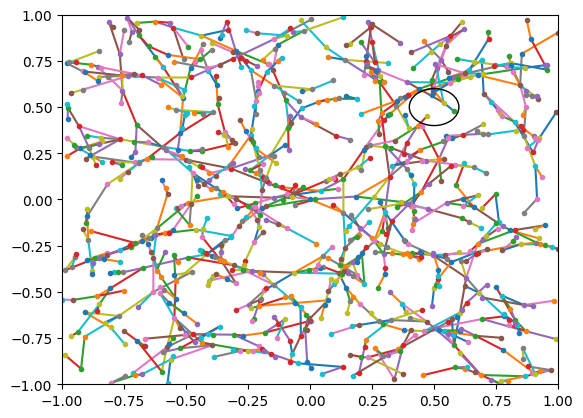

In [26]:
# Let's visualize the tree
fig = plt.figure()
ax = fig.add_subplot(111)

for s in tree:
    ax.plot(s[1], s[2], '.', zorder=2)
    # p = tuple_to_numpy(s)
    # draw_rectangle(ax, p[1:,:], p[0, 0])

    for c in tree[s]:
        ax.plot([s[1], c[1, 0]], [s[2], c[2, 0]], zorder=1)

# Plot target
ax.add_patch(Circle([x_target[1, 0], x_target[2, 0]], radius=0.1, fill=False, zorder=2));

plt.ylim(-1., 1.);
plt.xlim(-1., 1.);

In [ ]:
# Visualize closest path solution
states = []

def find_closest_node(x, tree):
    min_dist = np.inf
    s_min = None
    for s in tree:
        d = dist(tuple_to_numpy(s), x_target)
        if d < min_dist:
            min_dist = d
            s_min = s
    return s_min

def find_parent(x, tree):
    for s in tree:
        if len(tree[s]) == 0:
            continue
        l = np.array([tree[s]]).reshape((-1, 3))
        l = np.square(l - x.T).sum(axis=1)
        idx = np.argmin(l)
        if l[idx] < 1e-6:
            return tuple_to_numpy(s)
    return None

xd = find_closest_node(x_target, tree)
print(tuple_to_numpy(xd).T, 'vs', x_target.T)

p = tuple_to_numpy(xd)

states = []
while p is not None:
    states.append(p)
    p = find_parent(p, tree)

states = states[::-1]

visualize_trajectory(states)

RRT performance **has huge variance**. It can find the solution in a few iterations or not find it at all! How can we improve RRT convergence?

One easy way to improve RRT's performance is to introduce bias in the random sampling procedure towards the target. In other words, we need to change the `sample_state` function! One interesting random sampling procedure is the following:

$\boldsymbol{x}_{\text{sample}} = \boldsymbol{x}_{\text{start}} + \sigma_1\boldsymbol{\epsilon}_1 + \sigma_2|\epsilon_2|(\boldsymbol{x}_{\text{target}} - \boldsymbol{x}_{\text{start}})$

where $\boldsymbol{\epsilon}_1\sim\mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$, and $\epsilon_2\sim\mathcal{N}(0, 1)$. There are two small implications:

- We need to make sure that the $(x,y)$ parts of the state stay within the bound $[-1, 1]$
- We need to take proper differences between $\theta_{\text{target}}$ and $\theta_{\text{start}}$

Let's implement this new `sample_state()` function (and some helpers as well).

In [27]:
def diff(x_start, x_end):
    ### TO-DO: Compute x_end - x_start making sure that the angle differences are correctly computed (smallest angle difference)
    ### ANSWER: Insert code here
    theta = np.arctan2(np.sin(x_end[0] - x_start[0]), np.cos(x_end[0] - x_start[0]))
    
    x = x_end[1] - x_start[1]
    y = x_end[2] - x_start[2]
    
    d = np.array([theta, x, y])

    return d
    ### END of ANSWER

def sample_state(sigma_1 = 0.1, sigma_2 = 0.5):
    ### TO-DO: Sample a new state using the equation above. You should call np.random.randn twice! Use the `diff` function above. Remember to keep (x,y) in bounds.
    ### Use σ1=0.1, σ2=0.5
    ### ANSWER: Insert code here
    e1 = np.random.randn(3, 1)
    e2 = np.random.randn()

    x_sample = x_init + sigma_1 * e1 + sigma_2 * np.abs(e2) * diff(x_init, x_target)

    x_sample[0] = np.clip(x_sample[0], -np.pi, np.pi)
    x_sample[1:3] = np.clip(x_sample[1:3], -1, 1)
    
    return x_sample
    ### END of ANSWER

In [28]:
x1 = np.array([[0., 0., 0.]]).T
x2 = np.array([[np.pi, 2., 3.]]).T
x3 = np.array([[np.pi + 0.1, 2., -3.]]).T
x4 = np.array([[3. * np.pi, 2., -3.]]).T

assert(np.isclose(diff(x1, x2), -diff(x2, x1)).all())
assert(np.isclose(diff(x1, x2), x2).all())

assert(np.isclose(diff(x1, x3), -diff(x3, x1)).all())
assert(np.isclose(diff(x1, x3), -np.array([[np.pi - 0.1, -2., 3.]]).T).all())

assert(np.isclose(diff(x1, x4), -diff(x4, x1)).all())
assert(np.isclose(diff(x1, x4), np.array([[np.pi, 2., -3.]]).T).all())

assert(np.isclose(diff(x3, x2), -diff(x2, x3)).all())
assert(np.isclose(diff(x3, x2), np.array([[-0.1, 0., 6.]]).T).all())

assert(np.isclose(diff(x4, x2), -diff(x2, x4)).all())
assert(np.isclose(diff(x4, x2), np.array([[0., 0., 6.]]).T).all())

assert(np.isclose(diff(x3, x4), -diff(x4, x3)).all())
assert(np.isclose(diff(x3, x4), np.array([[-0.1, 0., 0.]]).T).all())


In [ ]:
import scipy.stats

data1 = []
data2 = []
for _ in range(200):
    data1.append(diff(np.zeros((3, 1)), sample_state(1., 0.)))
    data2.append(diff(np.zeros((3, 1)), x_init + np.random.randn(*x_init.shape)))

z, p = scipy.stats.mannwhitneyu(data1, data2)
assert(((2 * p) > 0.05).all())


In [ ]:
# Let's visualize the tree
fig = plt.figure()
ax = fig.add_subplot(111)

for _ in range(1000):
    s = numpy_to_tuple(sample_state())
    ax.plot(s[1], s[2], '.', zorder=2)

# Plot target
ax.add_patch(Circle([x_target[1, 0], x_target[2, 0]], radius=0.1, fill=False, zorder=2));

plt.ylim(-1., 1.);
plt.xlim(-1., 1.);

In [ ]:
np.random.seed(None) # reset seed
# Let's try it out
x_target = np.array([[np.pi, 0.5, -0.6]]).T # we can make the target more difficult now

# Initial position
x_init = np.array([[0., 0., 0.]]).T # Let's start at (0, 0, 0)

valid, tree = RRT(x_init, x_target, 1000)

print(valid, len(tree)) # returning false is OK!

In [ ]:
# Let's visualize the tree
fig = plt.figure()
ax = fig.add_subplot(111)

for s in tree:
    ax.plot(s[1], s[2], '.', zorder=2)
    # p = tuple_to_numpy(s)
    # draw_rectangle(ax, p[1:,:], p[0, 0])

    for c in tree[s]:
        ax.plot([s[1], c[1, 0]], [s[2], c[2, 0]], zorder=1)

# Plot target
ax.add_patch(Circle([x_target[1, 0], x_target[2, 0]], radius=0.1, fill=False, zorder=2));

plt.ylim(-1., 1.);
plt.xlim(-1., 1.);

In [ ]:
# Visualize closest path solution
states = []

def find_closest_node(x, tree):
    min_dist = np.inf
    s_min = None
    for s in tree:
        d = dist(tuple_to_numpy(s), x_target)
        if d < min_dist:
            min_dist = d
            s_min = s
    return s_min

def find_parent(x, tree):
    for s in tree:
        if len(tree[s]) == 0:
            continue
        l = np.array([tree[s]]).reshape((-1, 3))
        l = np.square(l - x.T).sum(axis=1)
        idx = np.argmin(l)
        if l[idx] < 1e-6:
            return tuple_to_numpy(s)
    return None

xd = find_closest_node(x_target, tree)
print(tuple_to_numpy(xd).T, 'vs', x_target.T)

p = tuple_to_numpy(xd)

states = []
while p is not None:
    states.append(p)
    p = find_parent(p, tree)

states = states[::-1]

visualize_trajectory(states)